In [1]:
import yfinance as yf
print(yf.__version__)


0.2.65


In [3]:
import pandas as pd
import numpy as np
import datetime
import pickle
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [4]:
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime.today()
df = yf.download("TSLA", start=start, end=end)
df = df.sort_index()
print("Dataset head:\n", df.head())

# Use OHLCV features
features = df[['Open', 'High', 'Low', 'Close', 'Volume']]

# -----------------------------
# Convert Close -> Returns (% change)
# -----------------------------
df['Return'] = df['Close'].pct_change()
df = df.dropna()

# Features (X) = OHLCV, Target (y) = Return
X = features.iloc[1:].values   # drop first row (due to NaN return)
y = df['Return'].values        # returns

C:\Users\navee\AppData\Local\Temp\ipykernel_28236\11373224.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("TSLA", start=start, end=end)
[*********************100%***********************]  1 of 1 completed

Dataset head:
 Price           Close       High        Low       Open    Volume
Ticker           TSLA       TSLA       TSLA       TSLA      TSLA
Date                                                            
2015-01-02  14.620667  14.883333  14.217333  14.858000  71466000
2015-01-05  14.006000  14.433333  13.810667  14.303333  80527500
2015-01-06  14.085333  14.280000  13.614000  14.004000  93928500
2015-01-07  14.063333  14.318667  13.985333  14.223333  44526000
2015-01-08  14.041333  14.253333  14.000667  14.187333  51637500


In [5]:
scaler_X = MinMaxScaler(feature_range=(0,1))
scaled_X = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler(feature_range=(0,1))
scaled_y = scaler_y.fit_transform(y.reshape(-1,1))

# Save scalers
with open("scaler_X.pkl","wb") as f:
    pickle.dump(scaler_X,f)
with open("scaler_y.pkl","wb") as f:
    pickle.dump(scaler_y,f)


In [6]:
print(len(scaled_X))

2699


In [7]:
# -----------------------------
# Train/Test Split
# -----------------------------
training_data_len = int(len(scaled_X) * 0.8)
train_X, test_X = scaled_X[:training_data_len], scaled_X[training_data_len:]
train_y, test_y = scaled_y[:training_data_len], scaled_y[training_data_len:]

# -----------------------------
# Create Sequences
# -----------------------------
def create_sequences(X, y, look_back=60):
    x_seq, y_seq = [], []
    for i in range(look_back, len(X)):
        x_seq.append(X[i-look_back:i])
        y_seq.append(y[i])
    return np.array(x_seq), np.array(y_seq)

look_back = 60
x_train, y_train = create_sequences(train_X, train_y, look_back)
x_test, y_test = create_sequences(test_X, test_y, look_back)

print("x_train shape:", x_train.shape)


x_train shape: (2099, 60, 5)


In [11]:
model = Sequential([
    LSTM(150, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
    Dropout(0.2),
    LSTM(150, return_sequences=False),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dense(1)  
])

model.compile(optimizer="adam", loss="mean_squared_error")


history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=50,
    validation_split=0.1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

# Save Model
model.save("model_returns.h5")


Epoch 1/50


c:\Users\navee\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: 0.0222 - val_loss: 0.0080
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.0075 - val_loss: 0.0079
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0075 - val_loss: 0.0095
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0075 - val_loss: 0.0081
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0074 - val_loss: 0.0082
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0071 - val_loss: 0.0080
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0073 - val_loss: 0.0092


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


C:\Users\navee\AppData\Roaming\Python\Python312\site-packages\matplotlib\cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
C:\Users\navee\AppData\Roaming\Python\Python312\site-packages\matplotlib\cbook.py:1355: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


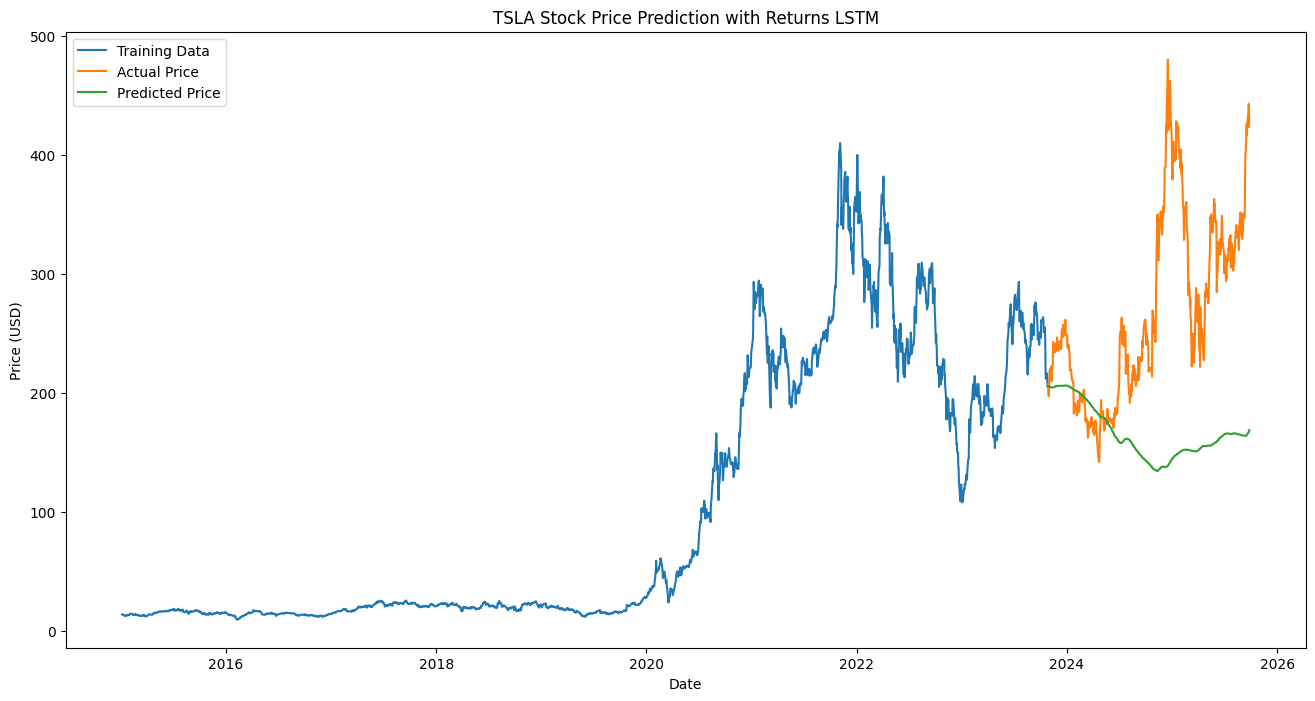

In [12]:

pred_scaled = model.predict(x_test)
pred_returns = scaler_y.inverse_transform(pred_scaled)

# Reconstruct prices from returns
# Start from the last known real price in test set
last_price = df['Close'].iloc[training_data_len + look_back - 1]
pred_prices = [last_price]

for r in pred_returns.flatten():
    pred_prices.append(pred_prices[-1] * (1 + r))

pred_prices = pred_prices[1:]  # drop first placeholder

# -----------------------------
# Plot Results
# -----------------------------
train = df.iloc[:training_data_len+look_back]
valid = df.iloc[training_data_len+look_back:].copy()
valid['Predicted'] = pred_prices[:len(valid)]

plt.figure(figsize=(16,8))
plt.title("TSLA Stock Price Prediction with Returns LSTM")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.plot(train['Close'], label="Training Data")
plt.plot(valid[['Close']], label="Actual Price")
plt.plot(valid[['Predicted']], label="Predicted Price")
plt.legend()
plt.show()
